In [11]:
import torch
import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm
import scipy as scip
from mpl_toolkits.axes_grid1 import make_axes_locatable
from copy import copy
from torch.nn import functional as F
from numpy.linalg import norm

from EWOthello.mingpt.probe_model import BatteryProbeClassification
from EWOthello.mingpt.utils import set_seed
from EWOthello.mingpt.model import GPTConfig,  GPTforProbeIA, GPTforProbeIA_ModV1
from EWOthello.data.othello import * 
from EWOthello.mingpt.dataset import CharDataset 
import EWOthello.utils.plot_helpers as plt_utils
from EWOthello.mingpt.utils import  intervene

set_seed(44)
print(torch.cuda.is_available())
device = torch.cuda.current_device()
print(torch.cuda.get_device_name(device))

True
NVIDIA GeForce RTX 3090 Ti


In [2]:
# Get a the game dataset
othello = get(ood_num=-1, data_root=None, num_preload=1) # 11 corresponds to over 1 million games
game_dataset = CharDataset(othello) 
print("Data Loaded \n")

Max num files: 230; Use_num: 1
['gen10e5__20220324_165952.pickle']


Mem Used: 0.4325 GB: 100%|██████████| 1/1 [00:00<00:00,  6.26it/s]

Deduplicating...


Deduplicating finished with 99999 games left
Using 20 million for training, 0 for validation
Dataset created has 99999 sequences, 61 unique words.
Data Loaded 



In [3]:
index = 499
x, _ = game_dataset[index]
tbf = [game_dataset.itos[_] for _ in x.tolist()]

probesLinear = [] # We need the pre-trained probes for the layer we want and all layers after it according to their theory
layer_s = 6
layer_e = 8+1
checkpoint_path = "../EWOthello/ckpts/DeanModels/"

for layer in range(layer_s, layer_e):
    print(f"Loading Pre-trained probe for layer: {layer}")
    probe = BatteryProbeClassification(device, probe_class=3, num_task=64, input_dim=512)
    probe.load_state_dict(torch.load(checkpoint_path + f"linearProbe_Map_new_8L8H_GPT_Layer{layer}.ckpt"))
    probe.eval()
    probesLinear.append(probe)

Loading Pre-trained probe for layer: 6
Loading Pre-trained probe for layer: 7
Loading Pre-trained probe for layer: 8


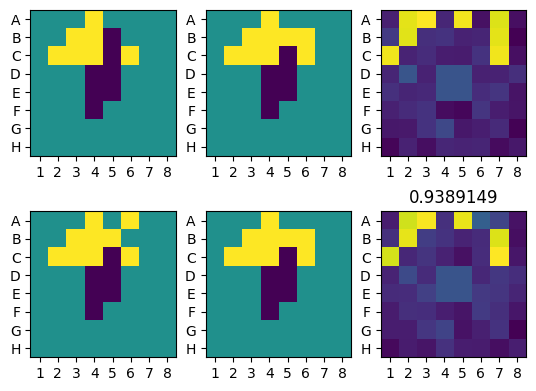

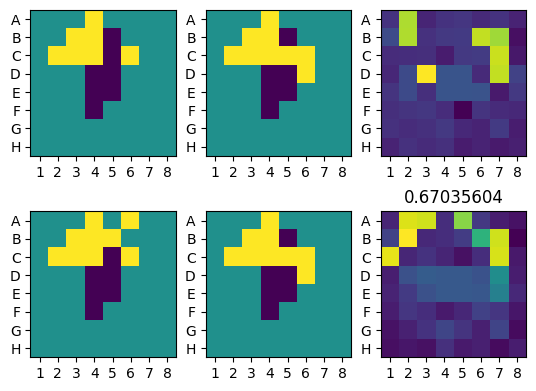

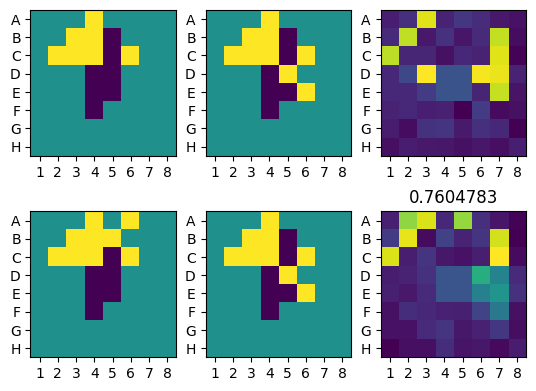

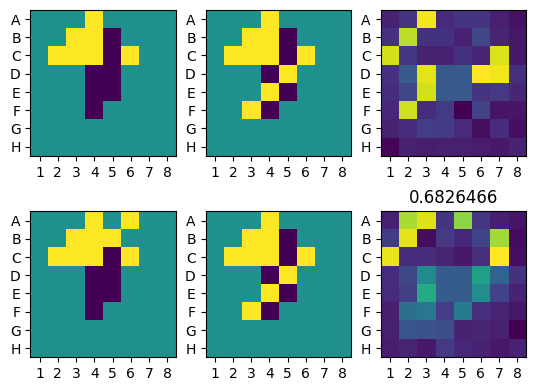

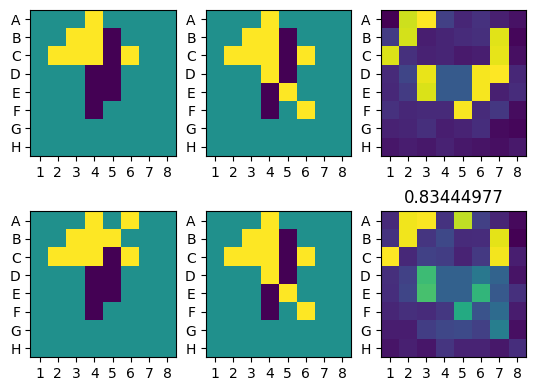

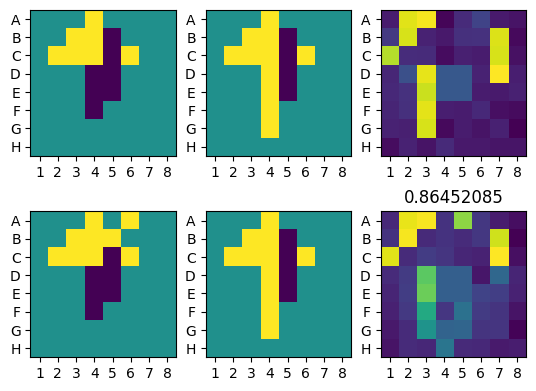

In [85]:
def convert_tbf_to_input(chunk, device, max_len=59):
    if len(chunk) != max_len:
        chunk += [-100] * (max_len - len(chunk))
    x_input = torch.tensor([game_dataset.stoi[tile] for tile in chunk], dtype=torch.long)
    return x_input[:-1].to(device)

def intervene_general(p, init_act, target_board, htd):
    new_mid_act = torch.tensor(init_act.clone().detach().cpu().numpy(), dtype=torch.float32).to(device)
    new_mid_act.requires_grad = True
    opt = torch.optim.Adam([new_mid_act], lr=htd["lr"])
    target_board = torch.tensor(target_board, dtype=torch.int64).to(device)
    for i in range(htd["steps"]):
        opt.zero_grad()
        logits_running = p(new_mid_act[None, :])[0][0]  # [64, 3]
        loss = F.cross_entropy(logits_running, target_board)        
        loss = torch.mean(loss)
        loss.backward()  # by torch semantics, loss is to be minimized
        opt.step()

    return new_mid_act

# Define the board that is passed in
number_played_moves = 10
ab = OthelloBoardState()
ab.update(tbf[:number_played_moves], prt=False)
init_board = np.array(ab.get_state()).reshape(8,8)
valid_moves = ab.get_valid_moves()
idx_of_interest = number_played_moves
padding = torch.zeros(2).cuda() # Add in center two tiles with zero padding because output skips over them

#
mconf = GPTConfig(vocab_size=61, block_size=59, n_layer=8, n_head=8, n_embd=512)
model = GPTforProbeIA_ModV1(mconf)
model.load_state_dict(torch.load("../EWOthello/ckpts/gpt_synthetic.ckpt"))
model.eval()
model = model.to(device) 

# 
htd = {"lr": 1e-3, "steps": 1000}
reassertion=False
intervene=True

# We need more than one valid moves for my test
if len(valid_moves) > 1:
    tbf_input = copy(tbf)[:number_played_moves]
    tbf_input.append(valid_moves[0])
    x_input = convert_tbf_to_input(tbf_input, device)
    ab_input = OthelloBoardState()
    ab_input.update(tbf_input[:number_played_moves+1], prt=False)
    input_board = np.array(ab_input.get_state())

    # Compute the true output logits for a different board
    for alt_move in valid_moves[1:]:        
        # Compute the logits for the alternative boards passed in
        tbf_gt = copy(tbf)[:number_played_moves]
        tbf_gt.append(alt_move)
        x_gt = convert_tbf_to_input(tbf_gt, device)

        act_gt = model.forward_1st_stage(layer_s, x_gt[None, :])[0]
        gt_board_logits, _ = probesLinear[0](act_gt[idx_of_interest,:])  
        gt_board = torch.argmax(gt_board_logits, -1, keepdim=False).detach().cpu().numpy()  
        pred_gt, _ = model.predict(model.forward_2nd_stage(act_gt[None], layer_s, -1)[0][0])
        pred_gt = pred_gt[idx_of_interest, 1:]
        pred_gt = torch.cat([pred_gt[:27], padding, pred_gt[27:33], padding, pred_gt[33:]], dim=0).detach().cpu().numpy()

        # Compute the logits for the board placed in by intervention
        intv_activation = model.forward_1st_stage(layer_s, x_input[None, :])[0]
        if intervene:
            new_activation = intervene_general(probesLinear[0], intv_activation[idx_of_interest,:], copy(gt_board[0]), htd)
            intv_activation[number_played_moves, :] = new_activation
        reconst_board, _ = probesLinear[0](intv_activation[number_played_moves, :])    
        reconst_board = torch.argmax(reconst_board, -1, keepdim=False).detach().cpu().reshape(8,8)
        
        if reassertion:
            for i, layer in enumerate(range(layer_s, layer_e-1)):
                intv_activation = model.forward_2nd_stage(intv_activation[None], layer, layer+1)[0][0]
                new_activation = intervene_general(probesLinear[i+1], intv_activation[idx_of_interest,:], copy(gt_board[0]), htd)
                intv_activation[idx_of_interest, :] = new_activation
        else:
            intv_activation = model.forward_2nd_stage(intv_activation[None], layer_s, -1)[0][0]
      
        post_intv_pred, _ = model.predict(intv_activation)
        post_intv_pred = post_intv_pred[idx_of_interest, 1:]
        post_intv_pred = torch.cat([post_intv_pred[:27], padding, post_intv_pred[27:33], padding, post_intv_pred[33:]], dim=0)
        post_intv_pred = post_intv_pred.detach().cpu().numpy()

        cosine_similarity = np.dot(post_intv_pred, pred_gt) / norm(post_intv_pred)/norm(pred_gt)
        fig = plt.figure()
        ax = plt_utils.addAxis(fig,2,3)
        ax[0].imshow(init_board)
        ax[1].imshow(gt_board.reshape(8,8))
        ax[2].imshow(pred_gt.reshape(8,8))
        ax[3].imshow(input_board.reshape(8,8))
        ax[4].imshow(reconst_board)
        ax[5].imshow(post_intv_pred.reshape(8,8))
        ax[5].set_title(cosine_similarity)
        plt_utils.format_ax_boardImage(ax)  


